# Quickstart Tutorial

MultiGrad allows you to easily implement data-parallelized, differentiable models in the Jax framework. All you need to provide is two Jax traceable functions: (1) a function that accepts model parameters and predicts a set of summary statistics that multigrad will automatically **sum over all MPI ranks**, and (2) a function that accepts the summary statistic predictions, compares them to a set of targets, and returns a loss function. All of the specific details of these functions are up to you!

In [1]:
from mpi4py import MPI
import jax.scipy
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import multigrad

## Example Model

Let's imagine we have a model that probabilistically predicts the stellar mass of a galaxy residing in a halo based on two parameters: a stellar-to-halo mass ratio $f$ and a scatter of $\sigma$ (both of which must be positive, and could reasonably span a range of orders of magnitude, so we will actually parameterize their logarithmic counterparts $\log f$ and $\log \sigma$). We will define the probability of a stellar mass given the halo mass using a log-normal distribution $P(\log M_\star | M_h; f, \sigma) = \mathcal{N}(\log f + \log M_h, \sigma)$. Imagine we have a simulated dataset of 10,000 halos with masses ranging from $10^{10}$ to $10^{11}$ $M_\odot$. We want to fit our model parameters to reproduce an observed stellar mass function, which is the number density of galaxies as a function of stellar mass $\Phi(\log M_\star)$.

In [2]:
# Generate fake halo masses between 10^10 < M_h < 10^11 as a power law
def load_halo_masses(num_halos=10_000, comm=MPI.COMM_WORLD):
    quantile = jnp.linspace(0, 0.9, num_halos)
    mhalo = 1e10 / (1 - quantile)

    # Assign halos evenly across given MPI ranks (only one rank for now)
    return np.array_split(mhalo, comm.size)[comm.rank]


# Compute one bin of the stellar mass function (SMF)
@jax.jit
def calc_smf_bin(params, logsm_low, logsm_high, volume, log_halo_masses):
    # Unpack model parameters f and sigma
    log_f, log_sigma = params
    mean_logsm = log_f + log_halo_masses
    sigma = 10 ** log_sigma

    # Integrating the log-normal PDF over the bin, we get erf:
    erf_high = 0.5 * (1 + jax.scipy.special.erf(
        (logsm_high - mean_logsm)/(jnp.sqrt(2) * sigma)))
    erf_low = 0.5 * (1 + jax.scipy.special.erf(
        (logsm_low - mean_logsm)/(jnp.sqrt(2) * sigma)))
    prob_in_bin = erf_high - erf_low

    # Sum probabilities, convert to number density, divide by bin width
    return jnp.sum(prob_in_bin) / volume / (logsm_high - logsm_low)


# Compute the stellar mass function over all bins (loop over calc_smf_bin)
@jax.jit
def calc_smf(params, smf_bin_edges, volume, log_halo_masses):
    smf = []
    logsm_low = smf_bin_edges[0]
    for logsm_high in smf_bin_edges[1:]:
        smf_bin = calc_smf_bin(
            params, logsm_low, logsm_high, volume, log_halo_masses)
        smf.append(smf_bin)
        logsm_low = logsm_high
    return jnp.array(smf)

## Inspecting the "truth"

We've now defined a model that will predict the stellar mass function, given two parameters and a set of halo data. Now we just have some auxiliary data to define, such as the volume spanned by our 10,000 halos and the stellar mass bins over which we are measuring the stellar mass function. Let's set a volume of 1.0 for simplicity (in whatever units happens to make this a reasonable assumption) and ten bins evenly dividing the range over $9 < \log M_\star < 10$.

Let's also set fiducial "truth" values for our stellar-to-halo mass fraction $\log f = -2$ and $\log \sigma = -0.5$ (roughly corresponding to $f = 0.01$ and $\sigma = 0.316$). Then, let's go ahead and "load" our simulated halos and compute the "true" stellar mass function, which will be our target summary statistic.

In [3]:
volume = 1.0
smf_bin_edges = jnp.linspace(9, 10, 11)

true_params = jnp.array([-2.0, -0.5])
log_halo_masses = jnp.log10(load_halo_masses(10_000))
true_smf = calc_smf(true_params, smf_bin_edges, volume, log_halo_masses)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


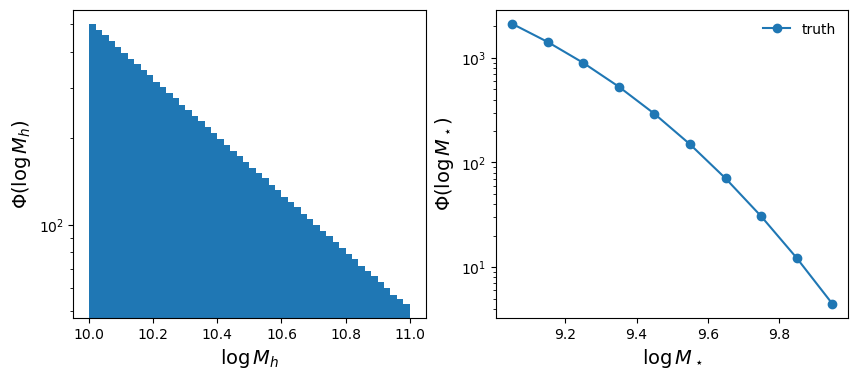

In [4]:
def plot_hmf_and_smf(smf, plotarg="C0o-", label=None, axes=None):
    if axes is None:
        _, axes = plt.subplots(ncols=2, figsize=(10, 4))
    axes[0].hist(log_halo_masses, bins=50, color="C0")
    axes[0].semilogy()
    axes[0].set_xlabel("$\\log M_h$", fontsize=14)
    axes[0].set_ylabel("$\\Phi(\\log M_h)$", fontsize=14)

    smf_bin_cens = 0.5 * (smf_bin_edges[:-1] + smf_bin_edges[1:])
    axes[1].semilogy(smf_bin_cens, smf, plotarg, label=label)
    axes[1].legend(frameon=False)
    axes[1].set_xlabel("$\\log M_\\star$", fontsize=14)
    axes[1].set_ylabel("$\\Phi(\\log M_\\star)$", fontsize=14)
    return axes

plot_hmf_and_smf(true_smf, label="truth")
plt.show()

## Introducing MultiGrad

To fit such a model with multigrad, we have to define a class that inherits from an abstract base class called `OnePointModel`. To make this class useable, you must define two methods: `calc_particle_sumstats_from_params` (which simply calls the `calc_smf` function we already defined above) and `calc_loss_from_sumstats` (which in this example simply computes a mean-squared error of the log of the stellar mass function in each bin). **Important:** The sumstats that we return **must** be summable over all ranks, so be careful not to return log quantities here. You can always take the logarithm of your sumstats in the loss function!

In [5]:
class MySMFModel(multigrad.OnePointModel):
    def calc_partial_sumstats_from_params(self, params):
        # Accessing global variables is fine, but I prefer to store them in
        # the `aux_data` attribute, which we will define during construction
        bin_edges = self.aux_data["smf_bin_edges"]
        volume = self.aux_data["volume"]
        log_halo_masses = self.aux_data["log_halo_masses"]

        return calc_smf(params, bin_edges, volume, log_halo_masses)

    def calc_loss_from_sumstats(self, sumstats):
        # Add 1e-10 so that log values always remain finite
        target_sumstats = jnp.log10(self.aux_data["target_sumstats"] + 1e-10)
        sumstats = jnp.log10(sumstats + 1e-10)
        # Reduced chi2 loss function assuming unit errors (mean squared error)
        return jnp.mean((sumstats - target_sumstats)**2)

In [6]:
aux_data = dict(
    log_halo_masses=log_halo_masses,
    smf_bin_edges=smf_bin_edges,
    volume=volume,
    target_sumstats=true_smf  # SMF at truth: params=(-2.0, 0.2)
)
model = MySMFModel(aux_data=aux_data)

In [7]:
# Since this notebook kernel is only a single MPI rank, the partial sumstats
# are identical to the total sumstats:
assert np.all(model.calc_partial_sumstats_from_params(true_params) ==
              model.calc_sumstats_from_params(true_params))

# Using the `calc_loss_and_grad_from_params` method:

# At the true set of parameters, the loss is at a global minimum of 0 :)
loss, gradloss = model.calc_loss_and_grad_from_params(true_params)
print("At true_params:")
print("Loss =", loss)
print("Grad(loss) =", gradloss)

# Perturbing these parameters yields a descendable gradient
loss, gradloss = model.calc_loss_and_grad_from_params(
    true_params + jnp.array([0.1, 0.1]))
print("At true_params + [0.1, 0.1]:")
print("Loss =", loss)
print("Grad(loss) =", gradloss)

At true_params:
Loss = 0.0
Grad(loss) = [0. 0.]
At true_params + [0.1, 0.1]:
Loss = 0.44032094
Grad(loss) = [2.6187496 4.2603974]


## Recovering the truth with gradient descent

MultiGrad provides several built-in gradient descent methods, notably Adam and BFGS. Adam is particularly useful for stochastic problems, but BFGS will likely be more powerful in this case. Running it is as simple as...

In [8]:
# Initial guess for our parameters. If it's too far off, there is always a
# risk of getting stuck in local minima or other zero-valued gradients
init_params = true_params + jnp.array([-1.5, 0.7])

# Run gradient descent using the BFGS method powered by scipy
results = model.run_bfgs(init_params)
print("BGFS has converged:", results.success, flush=True)
print("Initial guess =", init_params, flush=True)
print("True params =", true_params, flush=True)
print("Converged params =", results.x, flush=True)
print("\nFull results info:", flush=True)
print(results, flush=True)

BFGS Gradient Descent Progress:  15%|█▌        | 15/100 [00:00<00:02, 34.39it/s]

BGFS has converged: True
Initial guess = [-3.5         0.19999999]
True params = [-2.  -0.5]
Converged params = [-1.99999865 -0.50000094]

Full results info:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.930545117494024e-12
        x: [-2.000e+00 -5.000e-01]
      nit: 15
      jac: [-1.169e-05 -2.370e-05]
     nfev: 31
     njev: 31
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


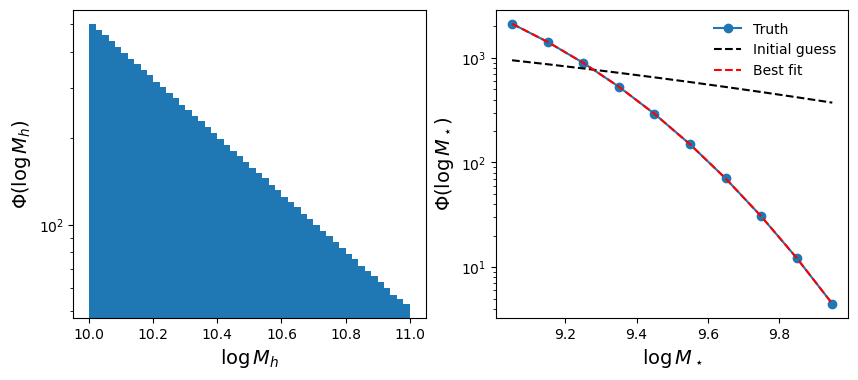

In [9]:
axes = plot_hmf_and_smf(true_smf, label="Truth")
axes = plot_hmf_and_smf(model.calc_sumstats_from_params(init_params),
                        "k--", label="Initial guess", axes=axes)
axes = plot_hmf_and_smf(model.calc_sumstats_from_params(results.x),
                        "r--", label="Best fit", axes=axes)

## The same thing, but parallel!

The power of multigrad is that it sums summary statistics over all given MPI ranks. Note that our halo loading function will automatically distribute the halos evenly across all available ranks, which is what makes this sum mathematically valid. So let's redo this whole fit, but this time in the script `smf_grad_descent.py` which is copied below (this is essentially just copy-and-pasting everything we've done in this notebook):

```python
"""
smf_grad_descent.py
"""

from mpi4py import MPI
import jax.scipy
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import multigrad


def load_halo_masses(num_halos=10_000, comm=MPI.COMM_WORLD):
    # Generate fake halo masses between 10^10 < M_h < 10^11 as a power law
    quantile = jnp.linspace(0, 0.9, num_halos)
    mhalo = 1e10 / (1 - quantile)

    # Assign halos evenly across given MPI ranks
    return np.array_split(mhalo, comm.size)[comm.rank]


# Compute one bin of the stellar mass function (SMF)
@jax.jit
def calc_smf_bin(params, logsm_low, logsm_high, volume, log_halo_masses):
    # Unpack model parameters f and sigma
    log_f, log_sigma = params
    mean_logsm = log_f + log_halo_masses
    sigma = 10 ** log_sigma

    # Integrating the log-normal PDF over the bin, we get erf:
    erf_high = 0.5 * (1 + jax.scipy.special.erf(
        (logsm_high - mean_logsm)/(jnp.sqrt(2) * sigma)))
    erf_low = 0.5 * (1 + jax.scipy.special.erf(
        (logsm_low - mean_logsm)/(jnp.sqrt(2) * sigma)))
    prob_in_bin = erf_high - erf_low

    # Sum probabilities, convert to number density, divide by bin width
    return jnp.sum(prob_in_bin) / volume / (logsm_high - logsm_low)


# Compute the stellar mass function over all bins (loop over calc_smf_bin)
@jax.jit
def calc_smf(params, smf_bin_edges, volume, log_halo_masses):
    smf = []
    logsm_low = smf_bin_edges[0]
    for logsm_high in smf_bin_edges[1:]:
        smf_bin = calc_smf_bin(
            params, logsm_low, logsm_high, volume, log_halo_masses)
        smf.append(smf_bin)
        logsm_low = logsm_high
    return jnp.array(smf)


def plot_hmf_and_smf(smf, logmh_per_rank=None, plotarg="C0o-",
                     label=None, axes=None):
    if axes is None:
        _, axes = plt.subplots(ncols=2, figsize=(10.5, 4))
    if logmh_per_rank is not None:
        colors = [f"C{i}" for i in range(len(logmh_per_rank))]
        axes[0].hist(logmh_per_rank, bins=np.linspace(10, 11, 50),
                     color=colors, stacked=True)
        for i in range(len(colors)):
            axes[0].hist([], bins=np.linspace(10, 11, 50),
                         color=f"C{i}", label=f"MPI Rank = {i}")
        axes[0].legend(frameon=False)
        axes[0].semilogy()
        axes[0].set_xlabel("$\\log M_h$", fontsize=14)
        axes[0].set_ylabel("$\\Phi(\\log M_h)$", fontsize=14)

    smf_bin_cens = 0.5 * (smf_bin_edges[:-1] + smf_bin_edges[1:])
    axes[1].semilogy(smf_bin_cens, smf, plotarg, label=label)
    if label is not None:
        axes[1].legend(frameon=False)
    axes[1].set_xlabel("$\\log M_\\star$", fontsize=14)
    axes[1].set_ylabel("$\\Phi(\\log M_\\star)$", fontsize=14)
    return axes


class MySMFModel(multigrad.OnePointModel):
    def calc_partial_sumstats_from_params(self, params):
        # Accessing global variables is fine, but I prefer to store them in
        # the `aux_data` attribute, which we will define during construction
        bin_edges = self.aux_data["smf_bin_edges"]
        volume = self.aux_data["volume"]
        log_halo_masses = self.aux_data["log_halo_masses"]

        return calc_smf(params, bin_edges, volume, log_halo_masses)

    def calc_loss_from_sumstats(self, sumstats):
        # Add 1e-10 so that log values always remain finite
        target_sumstats = jnp.log10(self.aux_data["target_sumstats"] + 1e-10)
        sumstats = jnp.log10(sumstats + 1e-10)
        # Reduced chi2 loss function assuming unit errors (mean squared error)
        return jnp.mean((sumstats - target_sumstats)**2)


if __name__ == "__main__":
    volume = 1.0
    smf_bin_edges = jnp.linspace(9, 10, 11)
    true_params = jnp.array([-2.0, -0.5])

    log_halo_masses = jnp.log10(load_halo_masses(10_000))
    logmh_per_rank = MPI.COMM_WORLD.allgather(log_halo_masses)  # for plotting

    # We must sum calc_smf over all MPI ranks this time
    # Could equivalently use model.calc_sumstats_from_params(true_params)
    true_smf = multigrad.reduce_sum(
        calc_smf(true_params, smf_bin_edges, volume, log_halo_masses))

    aux_data = dict(
        log_halo_masses=log_halo_masses,
        smf_bin_edges=smf_bin_edges,
        volume=volume,
        target_sumstats=true_smf  # SMF at truth: params=(-2.0, -0.5)
    )
    model = MySMFModel(aux_data=aux_data)

    # Initial guess for our parameters. If it's too far off, there is always a
    # risk of getting stuck in local minima or other zero-valued gradients
    init_params = true_params + jnp.array([-1.5, 0.7])

    # Run gradient descent using the BFGS method powered by scipy
    results = model.run_bfgs(init_params)

    init_smf = model.calc_sumstats_from_params(init_params)
    final_smf = model.calc_sumstats_from_params(results.x)
    # Print and plot results from the root rank only
    if not MPI.COMM_WORLD.rank:
        print("BGFS has converged:", results.success, flush=True)
        print("Initial guess =", init_params, flush=True)
        print("True params =", true_params, flush=True)
        print("Converged params =", results.x, flush=True)
        print("\nFull results info:", flush=True)
        print(results, flush=True)

        axes = plot_hmf_and_smf(
            true_smf, logmh_per_rank, label="Truth")
        axes = plot_hmf_and_smf(
            init_smf, None, "k--", label="Initial guess", axes=axes)
        axes = plot_hmf_and_smf(
            final_smf, None, "r--", label="Best fit", axes=axes)

        plt.savefig("smf_gradient_descent.png", bbox_inches="tight")
```

Now let's run this with three MPI ranks. Executing `mpiexec -n 3 python smf_gradient_descent.py` yields essentially the same output, but with each rank only loading 1/3 of the halo data. There is no speedup observed here due to the computation being very cheap with a small dataset of 10,000 halos, but if we increased this significantly, we would see a 3x speedup.

```txt
BFGS Gradient Descent Progress:  16%|█▌        | 16/100 [00:03<00:15,  5.26it/s]
BGFS has converged: True
Initial guess = [-3.5         0.19999999]
True params = [-2.  -0.5]
Converged params = [-2.00000006 -0.49999987]

Full results info:
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 4.862954657014473e-12
        x: [-2.000e+00 -5.000e-01]
      nit: 16
      jac: [ 5.082e-06  9.755e-06]
     nfev: 29
     njev: 29
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
```
![Results plot](./smf_gradient_descent.png)